# Final Project: Dinosaur Park
File: DinosaurPark.txt

This file contains a dataset describing ticket sales at a dinosaur park. 

## 1.0 Preparing Jupyter Notebook

### Package Downloads

In [1]:
#Import necessary packages and set options for jupyter notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
import warnings

### Jupyter Notebook Settings

In [2]:
#Set the maximum number of rows that can be observed
pd.set_option('display.max_rows', 45)
pd.set_option('display.max_columns',100)

### Function Creation

In [3]:
#Create a function that is going to plot data 
#It is called time series because that is the type of data it is going to be primarily be dealing with
def time_series(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [4]:
#Create a scatterplot graph
def scatter(xdata,ydata,title,xlabel,ylabel):
    plt.figure(figsize=(14,6))
    plt.scatter(xdata,ydata)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [5]:
#Create a seasonal decomposition of the different parts that make up the data
#Creating a subplot where the values are stacked up on one another makes it easier to read

def plot_seasonal_decomposition(data, period):
    decomposition = seasonal_decompose(data, period=period)

    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
#Create a rolling mean of the data to understand the trend

def roll_mean(df_column,window,title,xlabel,ylabel):

    plt.figure(figsize=(10,6))
    rolmean = df_column.rolling(window).mean()

    # Plot the original data and the rolling mean
    plt.figure(figsize=(10, 6))
    plt.plot(df_column, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean (window={window})')

    # Add title and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add legend and display plot
    plt.legend(loc='best')
    plt.show()

In [7]:
#Get the decomposed values which make up the time series
def decompose_seasonality(data, period):    

    decomposition = seasonal_decompose(data, period=period)

    original = data
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return original, trend, seasonal, residual

In [8]:
#Create a least squares line going through the data values

def plot_least_squares_line(x_value, y_value, title, x_label, y_label):
    plt.figure(figsize=(10,6))
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Predicting y values using the model
    y_pred = model.predict(x)

    # Plotting the original data and the least squares line
    plt.plot(x, y, label='original data', color='blue')
    plt.plot(x, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

def get_least_squares_line(x_value, y_value):
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Fitting the linear regression model
    model = LinearRegression()
    model.fit(x, y)

    # Getting the coefficients of the least squares line
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

In [10]:
def calculate_residuals(x_value, y_value, slope, intercept):
    # Extracting x and y values from the dataframe
    x = x_value.values.reshape(-1, 1).astype(float)
    y = y_value.astype(float)

    # Predicting y values using the provided slope and intercept
    y_pred = slope * x + intercept

    # Calculating residuals
    residuals = y - y_pred

    return residuals

In [11]:
#Create the Dickey Fuller test to use on data
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

In [12]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [13]:
from pmdarima import auto_arima

def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
    """
    Fits a SARIMA model to the provided data, searching over given parameter lists.
    It returns the best model based on AIC and also provides its BIC for comparison.
   
    Parameters:
    - data: Pandas Series of the time series data.
    - p_list, d_list, q_list: Lists of integers for the AR (p), differencing (d), and MA (q) parameters.
    - P_list, D_list, Q_list: Lists of integers for the seasonal AR (P), seasonal differencing (D),
                              and seasonal MA (Q) parameters.
    - s: Integer representing the length of the seasonal cycle.
   
    Returns:
    - A dictionary with the best model's AIC and BIC, along with the corresponding parameters.
    """
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

## 1.1 Data Preprocessing:
Load the dataset and convert the date information into a datetime object to facilitate time series analysis.

Check for missing values and anomalies, and handle them appropriately.

### Import data

In [14]:
#Import the dinosaur data and save it as dinosaur 
dinosaur = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Applied Statistics & Modeling/Final Project/Data Files/DinosaurPark.txt')
dinosaur 

,YEAR,MONTH,SALES
0,1992,1,3253
1,1992,2,3042
2,1992,3,3246
3,1992,4,3164
4,1992,5,3210
...,...,...,...
127,2002,8,7489
128,2002,9,6821
129,2002,10,7032
130,2002,11,8310


### Preprocess dataframe

In [15]:
#Convert the year and month columns to datetime

#Create a column of 1's to have it as the first day of the month
Day = np.ones(len(dinosaur))
dinosaur['DAY'] = Day

#Create the date column
date = pd.to_datetime(dinosaur[['YEAR','MONTH','DAY']])
dinosaur['Date'] = date
dinosaur

,YEAR,MONTH,SALES,DAY,Date
0,1992,1,3253,1.0,1992-01-01
1,1992,2,3042,1.0,1992-02-01
2,1992,3,3246,1.0,1992-03-01
3,1992,4,3164,1.0,1992-04-01
4,1992,5,3210,1.0,1992-05-01
...,...,...,...,...,...
127,2002,8,7489,1.0,2002-08-01
128,2002,9,6821,1.0,2002-09-01
129,2002,10,7032,1.0,2002-10-01
130,2002,11,8310,1.0,2002-11-01


In [16]:
#Drop the unncessary columns 
dinosaur.drop(columns={'YEAR','MONTH','DAY'},inplace=True)

In [17]:
#Rename column names
dinosaur.rename(columns={'SALES':'Sales'},inplace=True)

In [18]:
#Set the index of dataframe to date
dinosaur.set_index('Date',inplace=True)
dinosaur

,Sales
Date,
1992-01-01,3253
1992-02-01,3042
1992-03-01,3246
1992-04-01,3164
1992-05-01,3210
...,...
2002-08-01,7489
2002-09-01,6821
2002-10-01,7032


In [19]:
#Double check the columns are in the right format
#Expect '<M8[ns]' for index
#Expect 'float64' or 'int64' for monthly mean
print('Date dtype: ',dinosaur.index.dtype)
print('')
print('Daily Visitors dtype: ',dinosaur['Sales'].dtype)

Date dtype:  datetime64[ns]

Daily Visitors dtype:  int64


### Check for Missing Values

In [20]:
#Use isna is to create a series of true and false
#sum those to get a total number of missing values
#if it is 0 you can continue
dinosaur['Sales'].isna().sum()

0

### Check for Anomalies
There are a number of ways to do this. I am going to use the statistical format of creating z scores and see if any of them life outside a standard deviation zscore of 3.

In [21]:
#Create zscore value
dinosaur['zscore'] = (dinosaur['Sales'] - dinosaur['Sales'].mean()) / dinosaur['Sales'].std()

#Identify anomalies where their standard deviation is greater than 3
anomalies = dinosaur[abs(dinosaur['zscore']) > 3]

if len(anomalies) == 0:
    print("No anomalies detected.")
else:
    print("Anomalies detected:")
    print(anomalies)

Anomalies detected:
            Sales    zscore
Date                       
1999-12-01  11020  3.062911
2000-12-01  11050  3.080684
2001-12-01  12042  3.668366
2002-12-01  12144  3.728793


The anomalies happen on a consistient basis (the 12 month), this means that the data should not be removed as it is a part of the pattern of the data.

### Plot the scatterplot graph

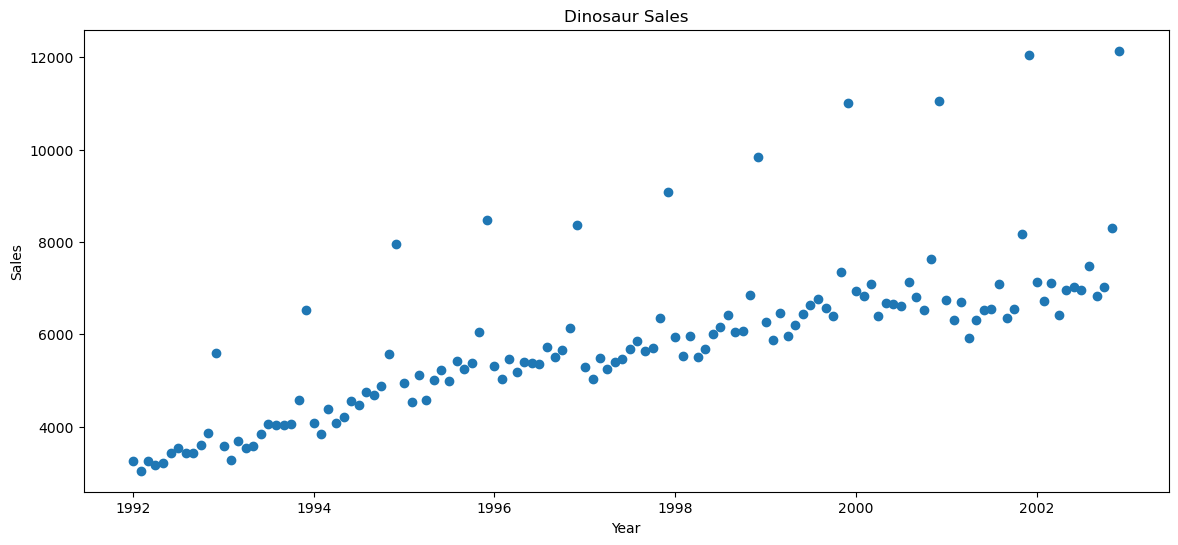

In [22]:
scatter(dinosaur.index,dinosaur['Sales'],'Dinosaur Sales','Year','Sales')

There is no need to aggregate data or make further changes, it is in the correct format to begin exploring

## 1.2 Exploratory Data Analysis: 
1. Visualize the data to understand trends, seasonality, and other characteristics.

2. Decompose the series to observe its components: trend, seasonality, and residuals.

### Visualise the data

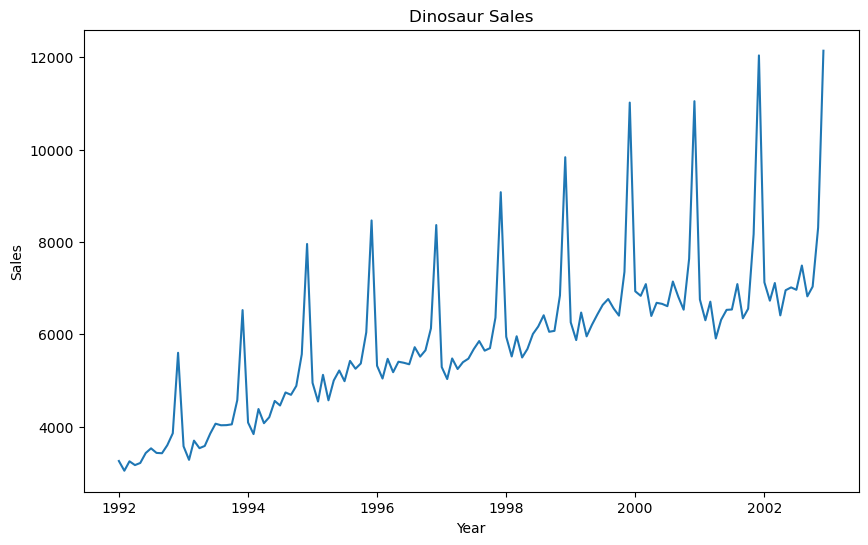

In [23]:
#Plot the time series graph of website visits data
time_series(dinosaur.index,dinosaur['Sales'],'Dinosaur Sales','Year','Sales')

There is clearly some patterns that can be observed in the data. There seems to be a monthly value which spikes up to a high value. There is also a trend to the data which can be further explored.

### Exploration of Seasonal Decomposition of Dinosaur Sales

#### Seasonality Period Decision
There is no given seasonality so there are 2 methods that I am going to use to determine the seasonal period
1. Visualisation
2. ACF & PACF Plots

##### 1. Visualisation of Seasonality Period Decision
Visualising a smaller portion of the day is going to help identify where the trends are.

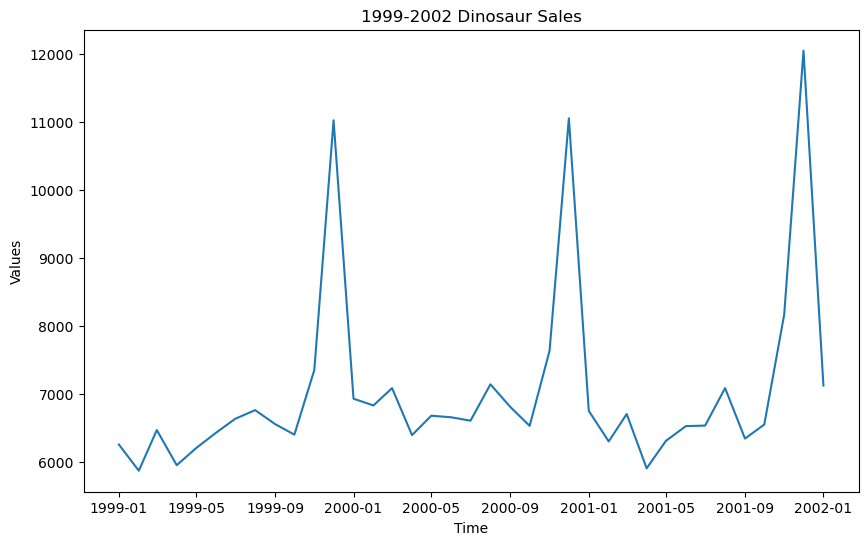

In [24]:
#Create a rolling mean graph of the data
dinosaur_time_period_1 = pd.DataFrame(dinosaur['Sales'].loc['1999-01-01':'2002-01-01'])
time_series(dinosaur_time_period_1.index,dinosaur_time_period_1['Sales'],'1999-2002 Dinosaur Sales','Time','Values')

This graph seems to show that there is a peak a month before the turn of the year. This is going to signify that the seasonal period is across a year.

##### 2. ACF & PACF Plots
Looking at the ACF and PACF plots is going to give insight for different things

1. ACF plot - Is looking at the moving average nature of the graph, this is how much values from lag k-1 impact lag k.

2. PACF plot - Is looking at the autoregressive nature of the graph, this is how values from lag k impact the current value

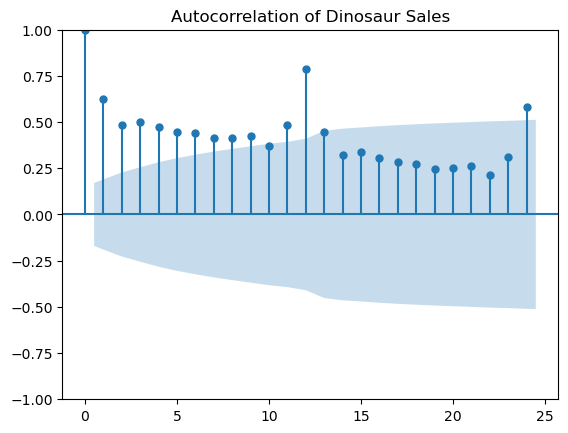

In [25]:
#Look at the acf plot to help determine the seasonal period
dinosaur_acf = plot_acf(dinosaur['Sales'],title= 'Autocorrelation of Dinosaur Sales',lags=24)

Observe that the high values are at months 12 and 24 which means that this leads towards a year as the seasonal period

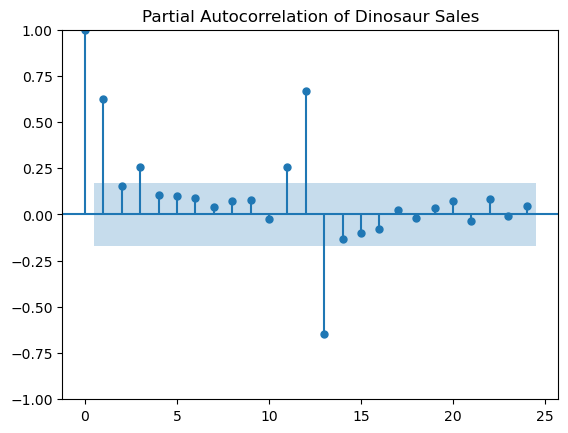

In [26]:
#Look at the pacf plot to help determine the seasonal period
dinosaur_pacf = plot_pacf(dinosaur['Sales'],title= 'Partial Autocorrelation of Dinosaur Sales',lags=24)

Similar to the autocorrelation there is a lag at 12 with a high correlation which means that this leads to a year as the seasonal period.

### Seasonal Decomposition of Dinosaur
Using a period of 1 year, breaking down the data into its individual components to understand how the data moves over time

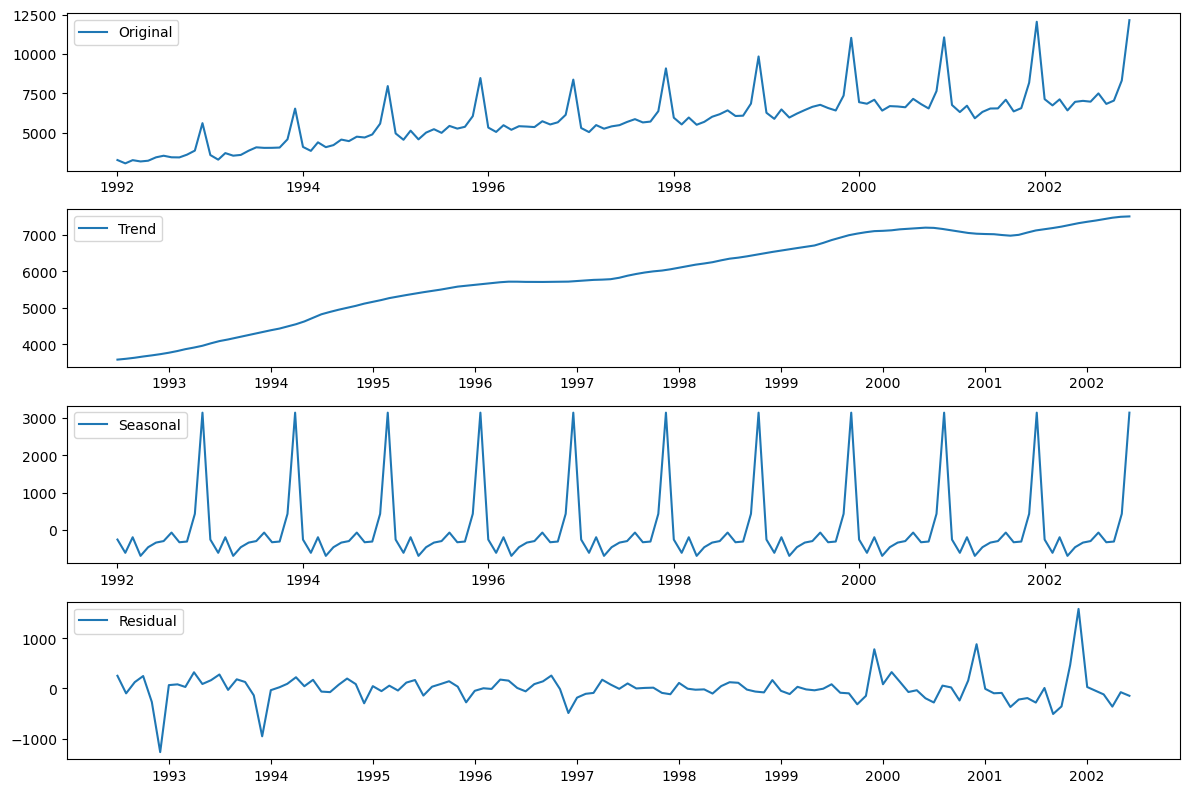

In [27]:
#Create a variable which can be referrenced to get each of the different series
#Plot the decomposition with a period of 1 year (12 instances)
dinosaur_seasonal_decomposition = decompose_seasonality(dinosaur['Sales'],12)
plot_seasonal_decomposition(dinosaur['Sales'],(12))

#### Trend of Dinosaur
There is a clear trend that is observed in the series above. This is increasing from 1992 to 2002. There is no cycles but this trend can be explored using the line of best fit

In [28]:
#Create an incrementing months columns so that a line of best fit can go through the data
dinosaur['Incrementing Month'] = range(1,len(dinosaur)+1)

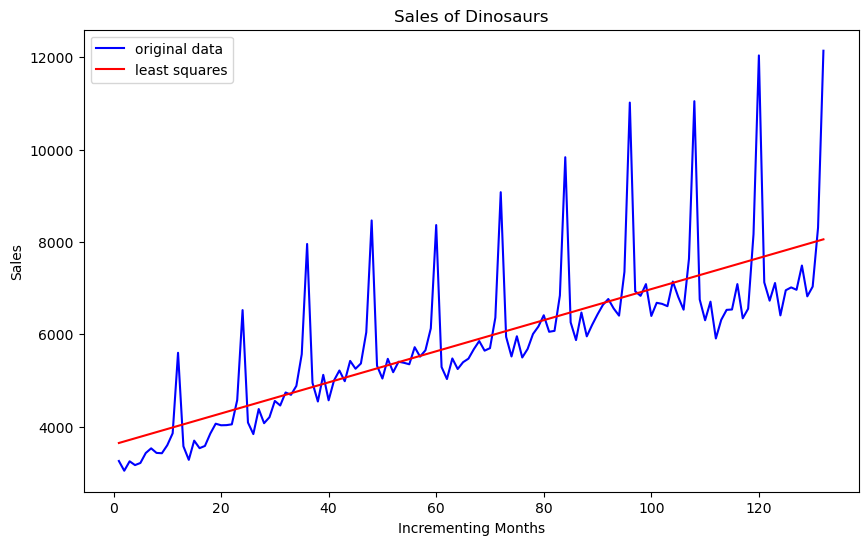

In [29]:
#plot the original data with the least squares line
plot_least_squares_line(dinosaur['Incrementing Month'],dinosaur['Sales'],'Sales of Dinosaurs','Incrementing Months','Sales')

There is an increasing trend in the sales of dinosaurs. This is not a stationary graph. With a graph that looks like that, you could use Holt's Seasonal Methods to continue this model. This will be explored in the forecasting section.

Another observation is that the peaks get bigger as time goes on. This is reflective of a multiplicative model.

In [30]:
adf_test(dinosaur['Sales'])

ADF Statistic:  -2.0886889021224047
P-Value:  0.24908710762762082
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


#### Seasonal of Dinosaur

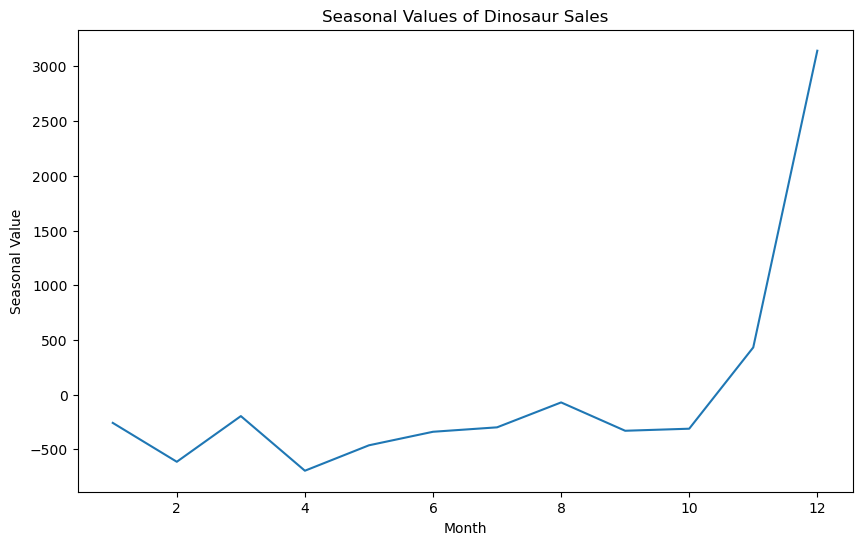

In [31]:
dinosaur_seasonal_values = pd.DataFrame(dinosaur_seasonal_decomposition[2].iloc[0:12])
dinosaur_seasonal_values['Incrementing Month'] = range(1,len(dinosaur_seasonal_values)+1)
time_series(dinosaur_seasonal_values['Incrementing Month'],dinosaur_seasonal_values['seasonal'],'Seasonal Values of Dinosaur Sales','Month','Seasonal Value')

The sales are steady around the year until it reaches December (month 12) where there is a large spike. Dinosaur sales might have something to do with Christmas as this looks as though it is a popular time of the year for dinosaurs to be on sale.

#### Residual of Dinosaur

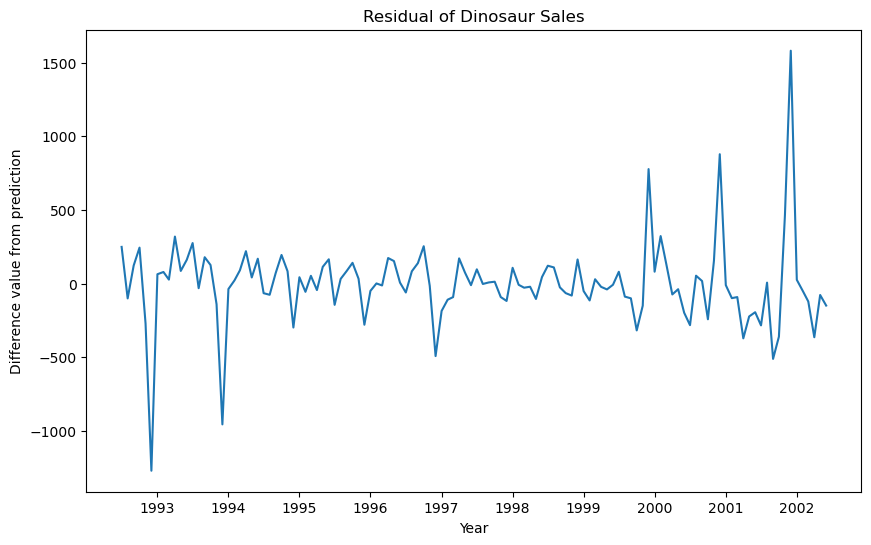

In [32]:
#Plot the residual of dinosaur sales
time_series(dinosaur_seasonal_decomposition[3].index,dinosaur_seasonal_decomposition[3],'Residual of Dinosaur Sales','Year','Difference value from prediction')

You can observe that the spike in December start large negatively and get smaller. Until the spikes get larger again. This is because each year the seasonal value in December it gets larger and larger. This is representative of autoregressive features of the data. The residual does fluctuate around a mean of 0 so the overall pattern of the data has been captured.

In [33]:
#Remove the seasonal values from the dinosaur sales
dinosaur_seasonally_adjusted = pd.DataFrame(dinosaur_seasonal_decomposition[0] - dinosaur_seasonal_decomposition[2])
dinosaur_seasonally_adjusted.rename(columns={dinosaur_seasonally_adjusted.columns[0]:'Value'},inplace=True)
dinosaur_seasonally_adjusted

,Value
Date,
1992-01-01,3510.861458
1992-02-01,3655.298958
1992-03-01,3441.886458
1992-04-01,3859.073958
1992-05-01,3672.765625
...,...
2002-08-01,7559.957292
2002-09-01,7150.911458
2002-10-01,7343.128125


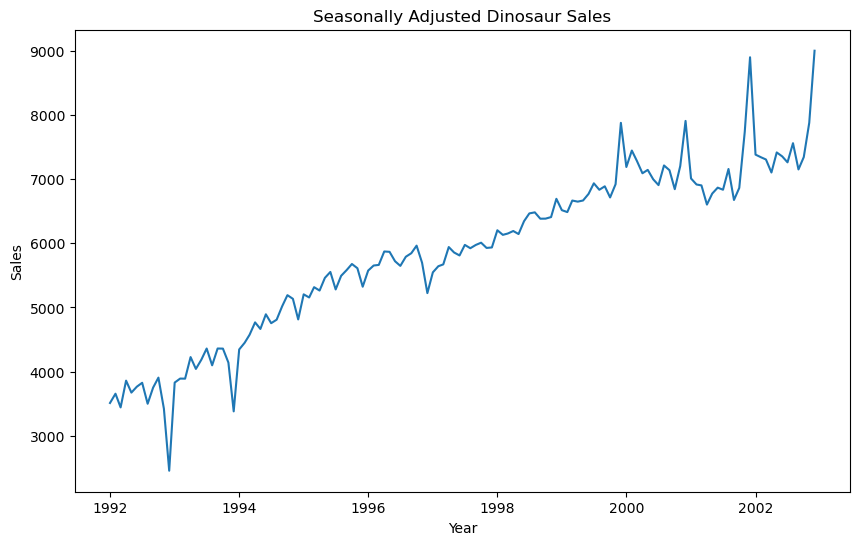

In [34]:
time_series(dinosaur_seasonally_adjusted.index,dinosaur_seasonally_adjusted['Value'],'Seasonally Adjusted Dinosaur Sales','Year','Sales')

After removing the seasonality, the same observation can be observed as was seen in the residual values. There seems to be another aspect of the graph that is increasing at a different rate than the rest. The 12th month is increasing ontop of the overall increasing trend. Need to adjust for this in forecasting by looking at the trend of the 12th values.

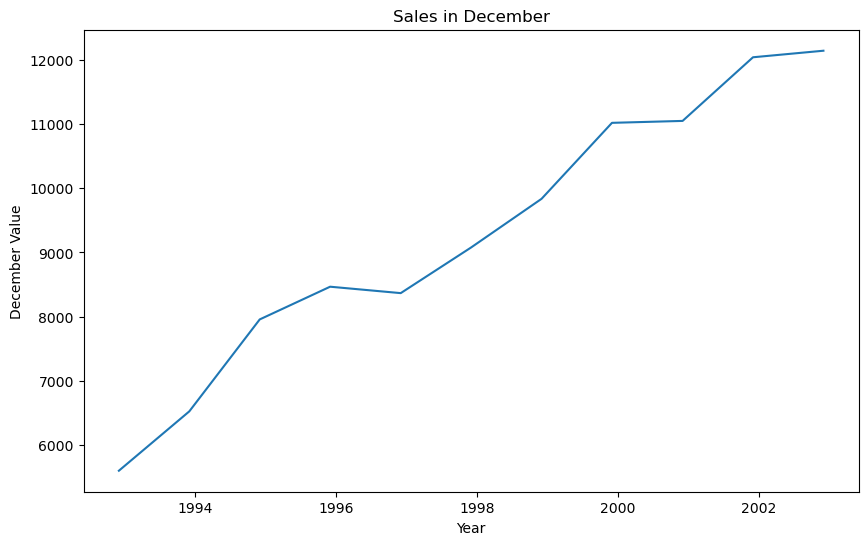

In [35]:
#Create a dataframe which looks at every 12th value
december_values = pd.DataFrame(dinosaur['Sales'].iloc[11::12])
december_values['Incrementing Year'] = range(1,len(december_values)+1)
time_series(december_values.index,december_values['Sales'],'Sales in December','Year','December Value')

Using a least squares line, take the residuals and if the values are spread equally above and below then the movement of the values in every 12 months is linear and can be useful in forecasting future data values.

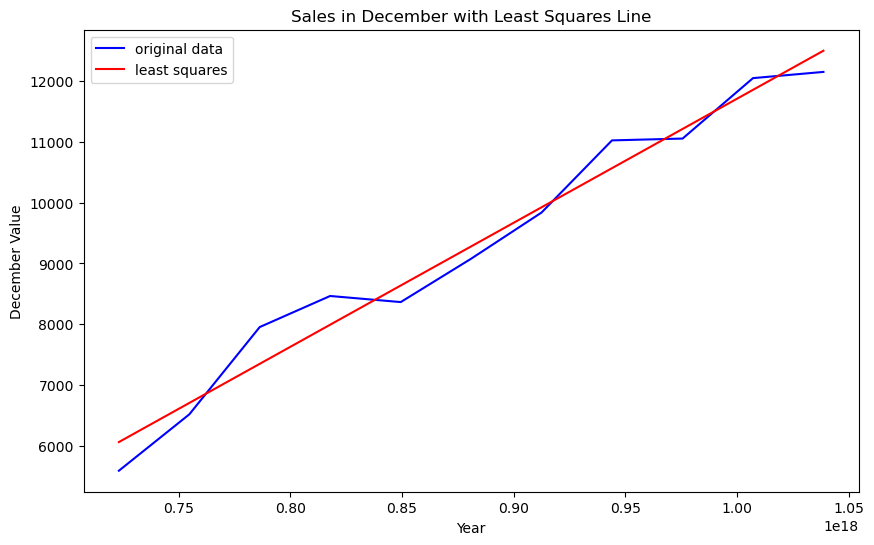

In [36]:
#Plot a least squares line against the trend of the yearly December values
plot_least_squares_line(december_values.index,december_values['Sales'],'Sales in December with Least Squares Line','Year','December Value')

In [37]:
#Get the least square line equation
slope = get_least_squares_line(december_values['Incrementing Year'],december_values['Sales'])[0]
intercept = get_least_squares_line(december_values['Incrementing Year'],december_values['Sales'])[1]
get_least_squares_line(december_values['Incrementing Year'],december_values['Sales'])

(642.4181818181822, 5425.399999999997)

In [38]:
def calculate_residuals(x_value, y_value, slope, intercept):
    # Extracting x and y values from the dataframe

    # Predicting y values using the provided slope and intercept
    y_pred = slope * x_value + intercept

    # Calculating residuals
    residuals = y_value - y_pred

    return residuals

In [39]:
def calculate_residuals_percentages(x_value, y_value, slope, intercept):

    # Predicting y values using the provided slope and intercept
    y_pred = slope * x_value + intercept

    # Calculating residuals
    residuals = y_value - y_pred
    
    # Calculating residuals as percentages
    residuals_percentages = (residuals / y_value) * 100

    return residuals_percentages


In [40]:
#Turn these residual differences into percentages
residual_percentage = calculate_residuals_percentages(december_values['Incrementing Year'],december_values['Sales'],slope,intercept)

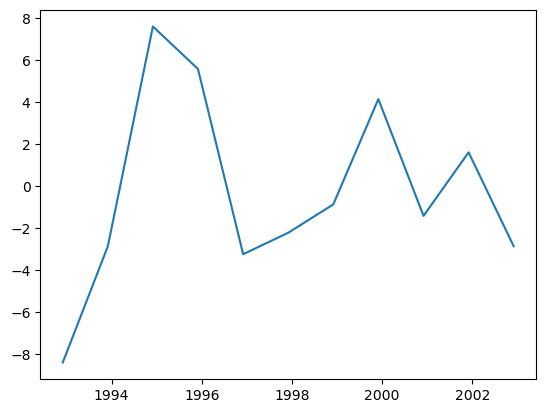

In [41]:
plt.plot(residual_percentage)

## 1.3 ARIMA Model Building:

1. Determine the order of differencing (d) needed to make the series stationary.

2. Identify the autoregressive term (p) and moving average term (q) using plots such as the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

3. Construct and fit the ARIMA model to the historical data.

#### ARIMA Modeling
The following ARIMA modeling types are going to be explored
- AR: Autoregressive Model (p value - using PACF to find order)
- MA: Moving Average Model (q value - using ACF to find order)
- ARMA: Autoregressive Moving Average (p value, q value)
- ARIMA: Autoregressive Integrated Moving Average (p value, d value, q value)
- SARIMA: Seasonal Autoregressive Integrated Moving Average (p value, d value, q value, P value, D value, Q value, seasonal). P value found through seasonal PACF, D value found through seasonal ADF statistic, Q value found through seasonal ACF

#### p,d,q values

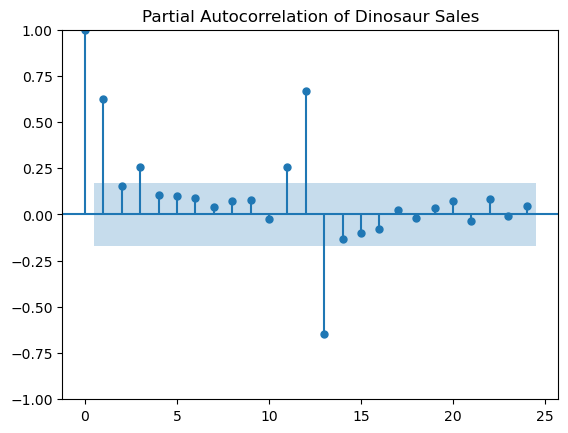

In [42]:
#Use the pacf plot to find the p model
dinosaur_pacf

In [43]:
#Create a list of p orders for dinosaur sales
p_orders_value = [1,12,13]

In [44]:
#Take the first difference to change the adf statistic 
dinosaur['First Difference'] = dinosaur['Sales'].diff()
dinosaur['Second Difference'] = dinosaur['First Difference'].diff()

In [45]:
#Look at the ADF statistic of the first difference
dinosaur_copy_1 = dinosaur[1:]
adf_test(dinosaur_copy_1['First Difference'])

ADF Statistic:  -2.9748113064660893
P-Value:  0.03731460738055275
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [46]:
#Look at the ADF statistic for the second difference
dinosaur_copy_2 = dinosaur_copy_1[1:]
adf_test(dinosaur_copy_2['Second Difference'])

ADF Statistic:  -11.727173081010706
P-Value:  1.3687841295731867e-21
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [47]:
#From the differencing you could take the first or the second difference for models
d_orders = [1,2]

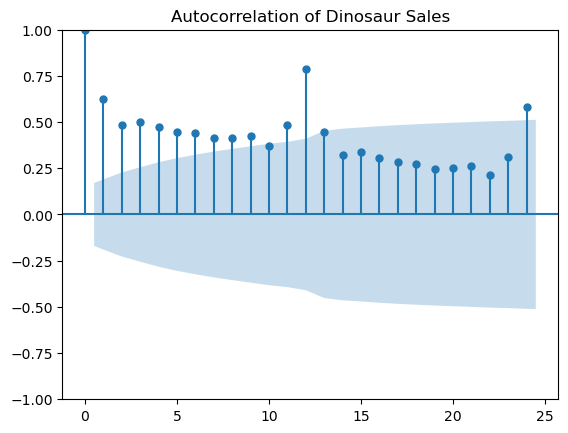

In [48]:
#Use the acf plot to find the q model
dinosaur_acf

In [49]:
#List the q orders for dinosaur sales
q_orders_value = [1,12,24]

#### P,D,Q Values

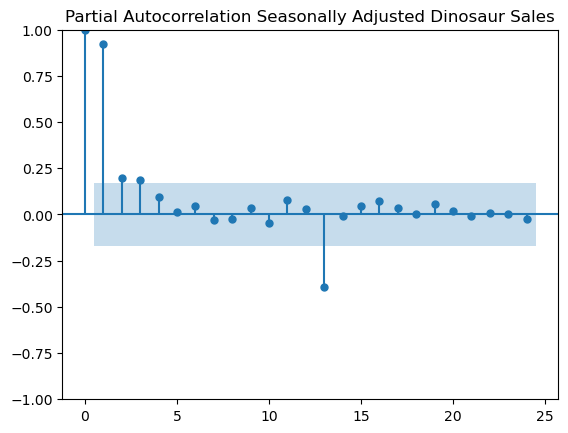

In [50]:
#Use the seasonally adjusted pacf to find P value
dinosaur_seasonally_adjusted_pacf = plot_pacf(dinosaur_seasonally_adjusted,title='Partial Autocorrelation Seasonally Adjusted Dinosaur Sales',lags=24)

In [51]:
#Create a list of P orders
P_orders_value = [1,13]

In [52]:
#Look at the ADF statistic to find D values
adf_test(dinosaur_seasonally_adjusted)

ADF Statistic:  -1.9682637697112113
P-Value:  0.3006592939358801
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [53]:
#Take the two differences as see how the adf statistic decreases
dinosaur_seasonally_adjusted['First Difference'] = dinosaur_seasonally_adjusted['Value'].diff()
dinosaur_seasonally_adjusted['Second Difference'] = dinosaur_seasonally_adjusted['First Difference'].diff()

In [54]:
dinosaur_sa_copy_1 = dinosaur_seasonally_adjusted[1:]
adf_test(dinosaur_sa_copy_1['First Difference'])
dinosaur_sa_copy_2 = dinosaur_sa_copy_1[1:]
adf_test(dinosaur_sa_copy_2['Second Difference'])

ADF Statistic:  -3.4520973482138215
P-Value:  0.00930601119513897
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58
ADF Statistic:  -8.539582577294555
P-Value:  9.86596600940754e-14
Critical Value: 
	1%: -3.49
	5%: -2.89
	10%: -2.58


In [55]:
#Create a list of D orders
D_orders_value = [1,2]

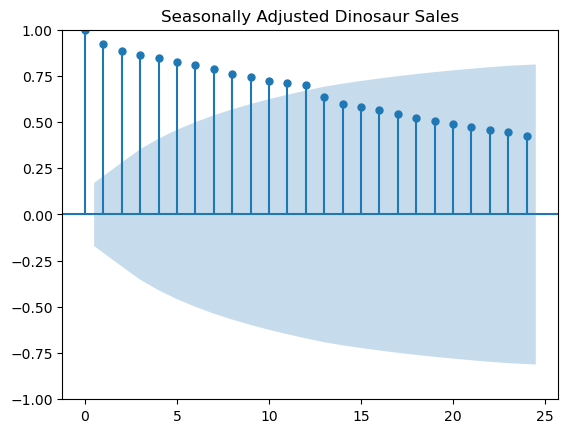

In [56]:
#Use the ACF plot to find the Q value
dinosaur_seasonally_adjusted_acf = plot_acf(dinosaur_seasonally_adjusted['Value'],title='Seasonally Adjusted Dinosaur Sales',lags=24)

In [57]:
#Create a list of Q orders
Q_orders_value = [1,2]

#### ARIMA/SARIMA Model Evaluation

In [58]:
#Create a list of different ARIMA models to choose from
evaluate_time_series_models(dinosaur['Sales'],p_orders_value,q_orders_value,d_orders)

,Model,Order,AIC,BIC
21,ARIMA,"(12, 1, 1)",1864.071460,1904.324222
27,ARIMA,"(13, 1, 1)",1865.119675,1908.247635
30,ARIMA,"(13, 2, 1)",1865.669007,1908.682024
24,ARIMA,"(12, 2, 1)",1866.141284,1906.286766
2,AR,"(13, 0, 0)",1868.467893,1911.709922
12,ARMA,"(13, 0, 1)",1871.699378,1917.824209
13,ARMA,"(13, 0, 12)",1881.658292,1959.493944
10,ARMA,"(12, 0, 12)",1885.061289,1960.014139
28,ARIMA,"(13, 1, 12)",1887.728520,1962.483651
11,ARMA,"(12, 0, 24)",1893.871093,2003.417567


In [59]:
#Select best SARIMA model outcome
select_best_sarima_model(dinosaur['Sales'],p_orders_value,d_orders,q_orders_value,P_orders_value,D_orders_value,Q_orders_value,12)

{'aic': 1618.6061329683816,
 'bic': 1626.9435034477162,
 'pdq': (0, 1, 2),
 'seasonal_pdq': (0, 1, 0, 12)}